# Sparse Hebbian Learning: toward a quantitative measure of the quality of filters

We are interested here in learning the "optimal" components of a set of images (let's say some "natural", usual images). As there is no supervisor to guide the learning, this is called unsupervised learning. Our basic hypothesis to find the best ("optimal") components will be to assume that *a priori* the most sparse is more plausible. We will implement the derived algorithm in this set of scripts.



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(precision=4, suppress=True)
import pandas as pd

## experiments

To test and control for the role of different parameters, we will have a first object (in the [shl_experiments.py](https://github.com/bicv/SHL_scripts/blob/master/shl_scripts/shl_experiments.py) script) that controls a learning experiment. It contains all relevant parameters, but can also keep a trace of the history of some statistics. This is useful to compare the relative efficiency of the different solutions.


In [3]:
DEBUG_DOWNSCALE, verbose = 10, 0
DEBUG_DOWNSCALE, verbose = 1, 0
DEBUG_DOWNSCALE, verbose = 10, 10
DEBUG_DOWNSCALE, verbose = 1, 10

tag = 'independance'

nb_quant = 128
nb_quant = 256
C = 5.
eta_homeo=0.05
alpha_homeo=0.02
do_double_shuffle = True
do_double_shuffle = False
do_random = True

n_iter = 2**13 + 1

record_num_batches = 2**11
N_show = 120
max_patches = 10
seed = 42
np.random.seed(seed)

opts = dict(DEBUG_DOWNSCALE=DEBUG_DOWNSCALE, n_iter=n_iter, 
            eta_homeo=eta_homeo, alpha_homeo=alpha_homeo, 
            C=C, nb_quant=nb_quant, P_cum=None, verbose=verbose)


from shl_scripts.shl_experiments import SHL
shl = SHL(**opts)
data = shl.get_data(matname=tag)

Extracting data..loading the data called : data_cache/independance_data
Data is of shape : (81920, 144) - done in 0.08s.


In [4]:
!ls -l {shl.data_cache}/{tag}*
!rm -fr {shl.data_cache}/{tag}*lock*

-rw-r--r--  1 laurentperrinet  staff   2533678 Feb 17 01:28 data_cache/independance_HEH_dico.pkl
-rw-r--r--  1 laurentperrinet  staff   1450227 Feb 17 01:40 data_cache/independance_None_dico.pkl
-rw-r--r--  1 laurentperrinet  staff  94371968 Feb 16 23:18 data_cache/independance_data.npy


In [5]:
print('number of patches, size of patches = ', data.shape)
print('average of patches = ', data.mean(), ' +/- ', data.mean(axis=1).std())
SE = np.sqrt(np.mean(data**2, axis=1))
print('average energy of data = ', SE.mean(), '+/-', SE.std())

number of patches, size of patches =  (81920, 144)
average of patches =  -4.495470547626767e-05  +/-  0.008112619110527658
average energy of data =  0.059129945786532565 +/- 0.07003870671389546


In [6]:
stick = np.arange(shl.n_dictionary)*nb_quant

indx = np.random.permutation(data.shape[0])[:record_num_batches]
P_cum_zeroeffect = np.linspace(0, 1, nb_quant, endpoint=True)[np.newaxis, :] * np.ones((shl.n_dictionary, 1))


## learning

The actual learning is done in a second object (here ``dico``) from which we can access another set of properties and functions  (see the [shl_learn.py](https://github.com/bicv/SHL_scripts/blob/master/shl_scripts/shl_learn.py) script):

loading the dico called : data_cache/independance_HEH_dico.pkl
size of dictionary = (number of filters, size of imagelets) =  (529, 144)
average of filters =  5.920540413985742e-05 +/- 0.008490935654465303
average energy of filters =  1.0 +/- 8.234341763631113e-17
loading the dico called : data_cache/independance_None_dico.pkl
size of dictionary = (number of filters, size of imagelets) =  (529, 144)
average of filters =  1.926869283434367e-06 +/- 0.008182779497631456
average energy of filters =  1.0 +/- 8.416260815883698e-17


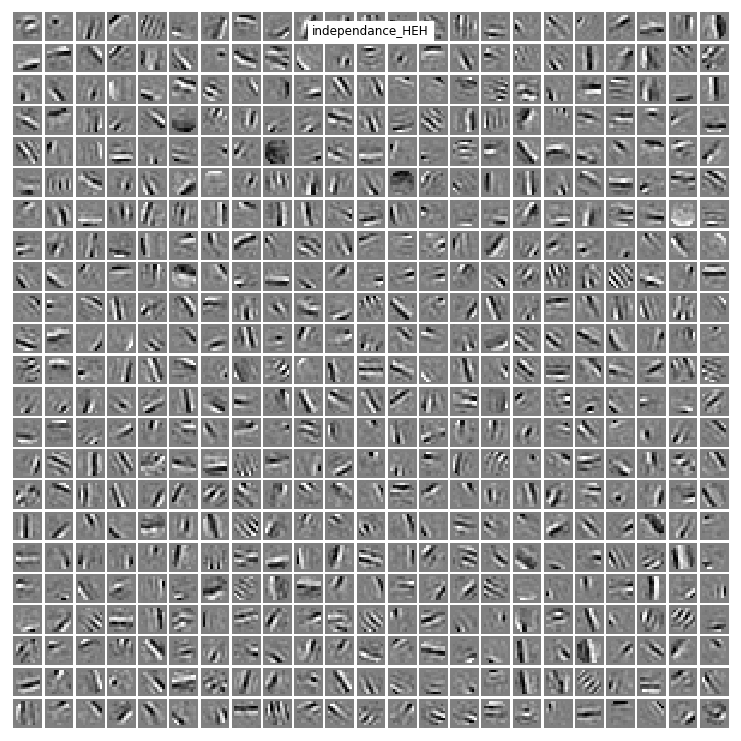

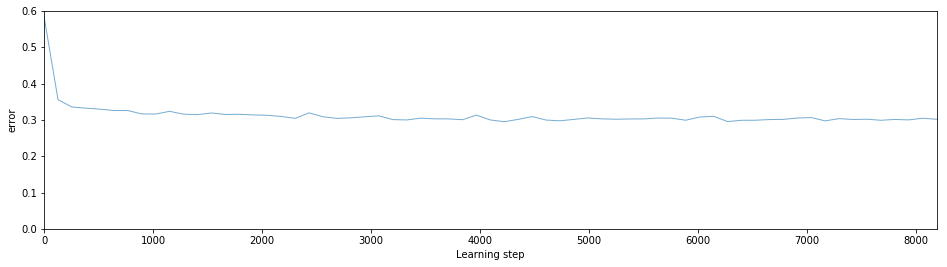

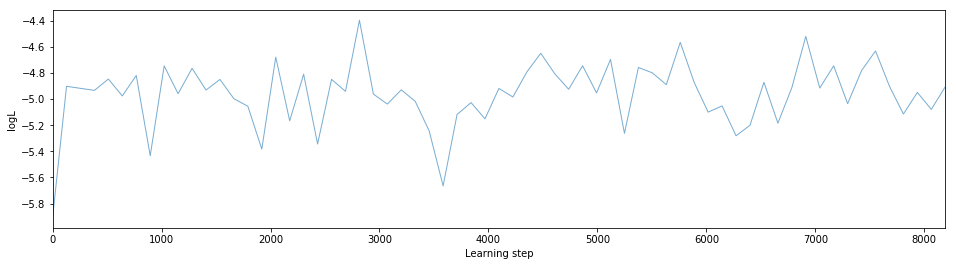

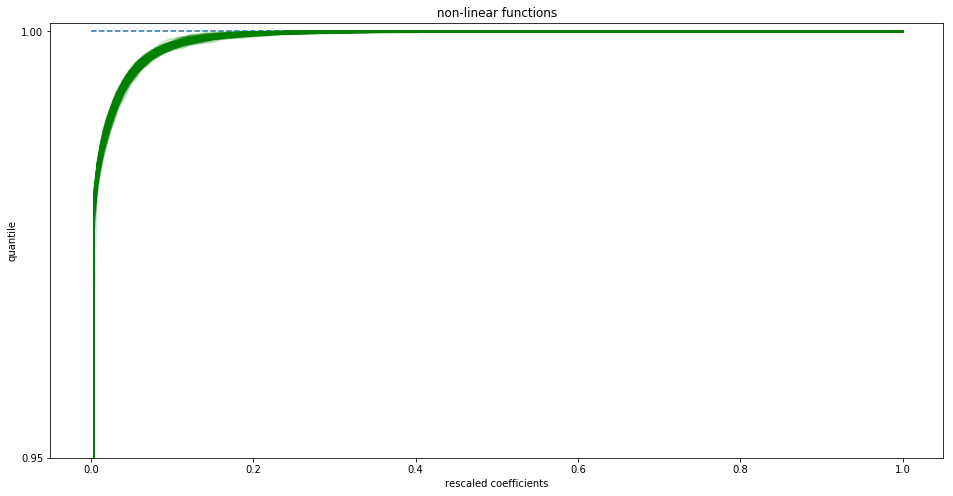

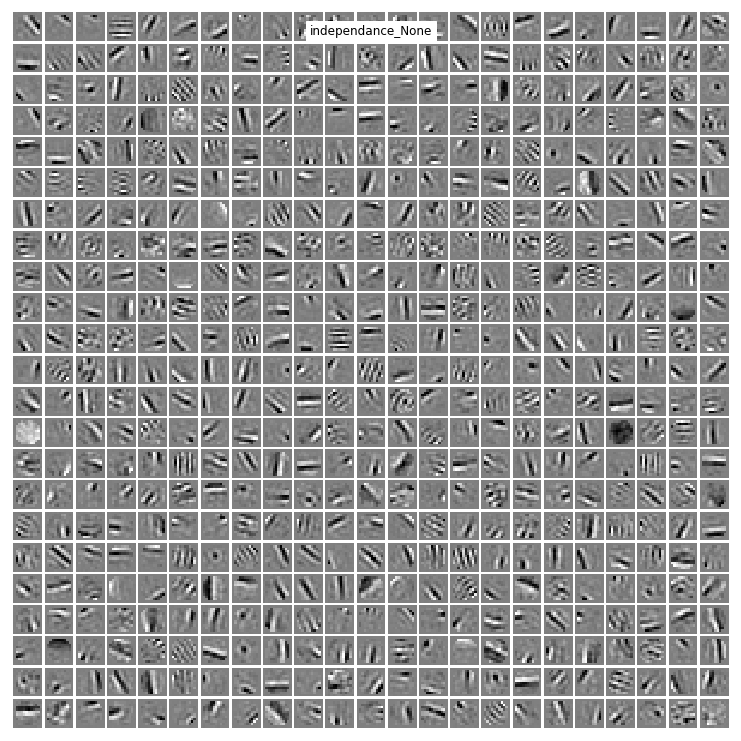

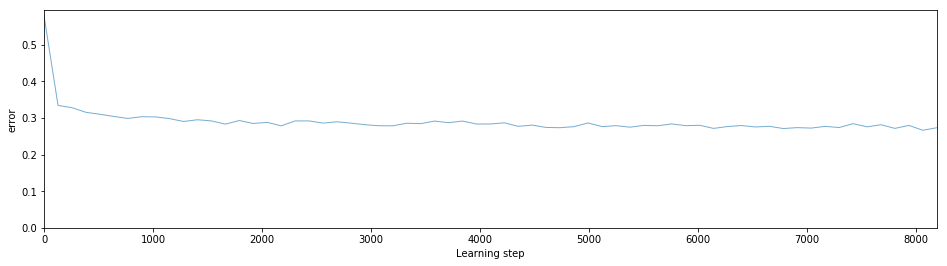

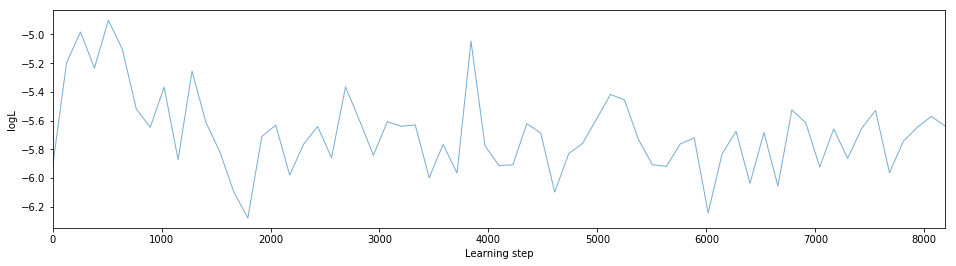

In [7]:
list_figures = ['show_dico', 'time_plot_error', 'time_plot_logL']

dico = {}
for homeo_method in ['HEH', 'None']:
    shl = SHL(homeo_method=homeo_method, **opts)
    dico[homeo_method] = shl.learn_dico(data=data, list_figures=list_figures, matname=tag + '_' + homeo_method)

    print('size of dictionary = (number of filters, size of imagelets) = ', dico[homeo_method].dictionary.shape)
    print('average of filters = ',  dico[homeo_method].dictionary.mean(axis=1).mean(), 
          '+/-',  dico[homeo_method].dictionary.mean(axis=1).std())
    SE = np.sqrt(np.sum(dico[homeo_method].dictionary**2, axis=1))
    print('average energy of filters = ', SE.mean(), '+/-', SE.std())

    if not dico[homeo_method].P_cum is None: 
        from shl_scripts.shl_tools import plot_P_cum
        fig, ax = plot_P_cum(dico[homeo_method].P_cum, verbose=False, alpha=.15);
        ax.set_ylim(0.95, 1.001)
        #ax.set_xmargin(0.);

## theory



Sum of non-zero coefficients 31015 ~= 30720
average non-zeros 58.629489603024574 ~= 58.071833648393195


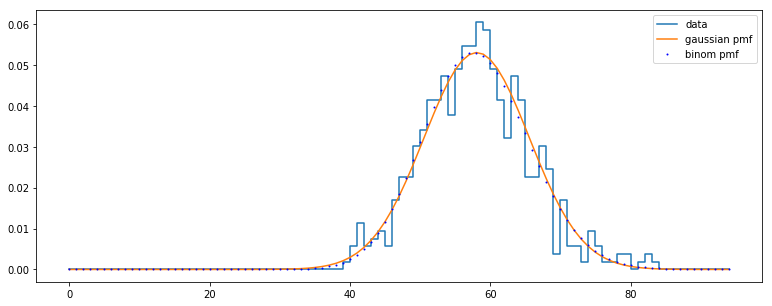

In [8]:
from scipy.stats import binom
# define the mean
rho = shl.l0_sparseness / shl.n_dictionary

# draw binomial samples
sparse_code_binary = np.random.rand(record_num_batches, shl.n_dictionary) > 1 - rho

# define the theoretical standard deviation
sd = np.sqrt(rho*(1-rho)*record_num_batches)

# the binomial probability is defined from 0 to record_num_batches \times shl.n_dictionary
# for visualization, we show the part around non-zero probabilities:
record_num_batches_high = int(rho * record_num_batches + 5. * sd)
bins = np.arange(record_num_batches_high)

print('Sum of non-zero coefficients', sparse_code_binary.sum(), '~=', shl.l0_sparseness*record_num_batches)
print('average non-zeros', np.count_nonzero(sparse_code_binary, axis=0).mean(), '~=', rho*record_num_batches)
fig, ax= plt.subplots(figsize=(13, 5))
smarts, edges = np.histogram(np.count_nonzero(sparse_code_binary, axis=0), density=True, bins=bins)
smarts /= smarts.sum()
ax.step(edges, np.hstack((smarts, 0)), where='pre', label='data');
#edges_mid = .5*( edges[1:] + edges[:-1] )
#print(rho, s, edges)
proba = np.exp(-.5 * (edges - rho*record_num_batches)**2 / sd**2)
proba /= proba.sum()
ax.plot(edges, proba, label='gaussian pmf');
proba_binom = binom.pmf(edges, record_num_batches, rho)
proba_binom /= proba_binom.sum()
ax.plot(edges, proba_binom, 'bo', ms=1, label='binom pmf')
ax.legend()

## coding

The learning itself is done via a gradient descent but is highly dependent on the coding / decoding algorithm. This belongs to a another function (in the [shl_encode.py](https://github.com/bicv/SHL_scripts/blob/master/shl_scripts/shl_encode.py) script)

In [9]:
from shl_scripts.shl_tools import show_data
def print_stats(data, dictionary, sparse_code):
    print(42*'🐒')

    print('number of codes, size of codewords = ', sparse_code.shape)
    print('average of codewords = ', sparse_code.mean())
    print('average std of codewords = ', sparse_code.std())
    print('l0-sparseness of codewords = ', (sparse_code>0).mean(), ' ~= l0/M =', shl.l0_sparseness/shl.n_dictionary)
    print('std of the average of individual patches = ', sparse_code.mean(axis=0).std())


    plt.matshow(sparse_code[:N_show, :])
    plt.show()
    fig, axs = show_data(data[:max_patches, :])
    plt.show()

    patches = sparse_code @ dictionary
    error = data - patches
    
    print('number of codes, size of reconstructed images = ', patches.shape)

    fig, axs = show_data(patches[:max_patches, :])
    plt.show()
    fig, axs = show_data(error[:max_patches, :], cmax=np.max(np.abs(patches[:max_patches, :])))
    plt.show()
    print('average of data patches = ', data.mean(), '+/-', data.mean(axis=1).std())
    print('average of residual patches = ', error.mean(), '+/-', error.mean(axis=1).std())
    SD = np.sqrt(np.mean(data**2, axis=1))

    print('median energy of data = ', np.median(SD))
    print('average energy of data = ', SD.mean(), '+/-', SD.std())
    
    SE = np.sqrt(np.mean(error**2, axis=1))

    print('average energy of residual = ', SE.mean(), '+/-', SE.std())
    print('median energy of residual = ', np.median(SE))
    print('average gain of coding = ', (SD/SE).mean(), '+/-', (SD/SE).std())
    
    return SD, SE

🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒
number of codes, size of codewords =  (2048, 529)
average of codewords =  0.004024343128544705
average std of codewords =  0.04436552094678571
l0-sparseness of codewords =  0.028297236826559546  ~= l0/M = 0.02835538752362949
std of the average of individual patches =  0.001255233793486059


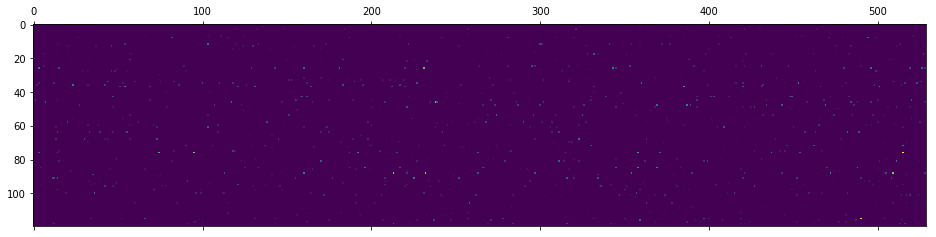

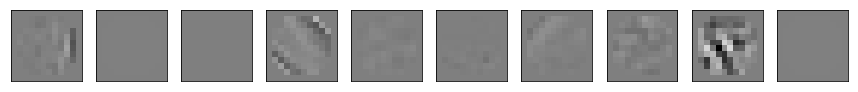

number of codes, size of reconstructed images =  (2048, 144)


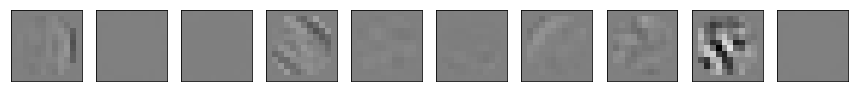

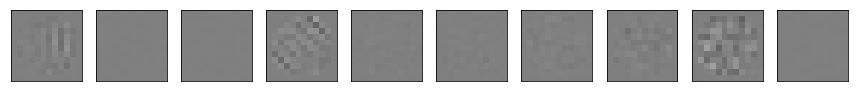

average of data patches =  1.162793067911255e-05 +/- 0.0076012877829628655
average of residual patches =  -6.475595219154925e-05 +/- 0.00265324766707694
median energy of data =  0.028686129676146165
average energy of data =  0.05708034923256437 +/- 0.06890564239757233
average energy of residual =  0.017561360896801433 +/- 0.020894639911121362
median energy of residual =  0.008936565661357601
average gain of coding =  3.558990895031439 +/- 1.060939479219611
🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒
number of codes, size of codewords =  (2048, 529)
average of codewords =  0.004039441380681249
average std of codewords =  0.044632094959664685
l0-sparseness of codewords =  0.028313851311436673  ~= l0/M = 0.02835538752362949
std of the average of individual patches =  0.001316098007921894


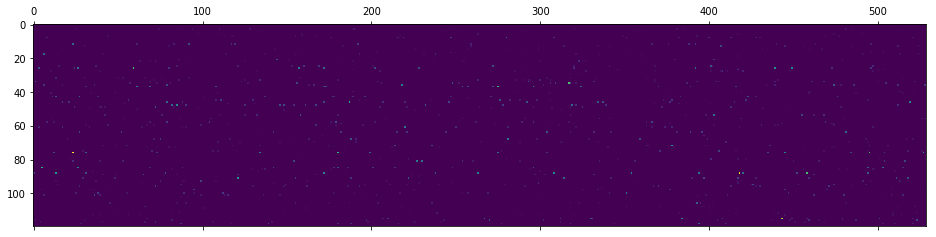

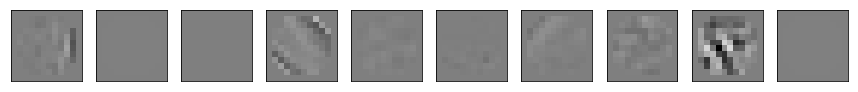

number of codes, size of reconstructed images =  (2048, 144)


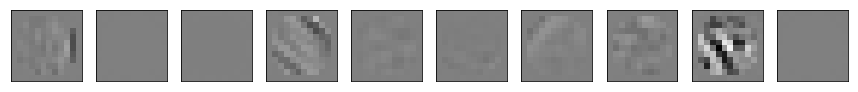

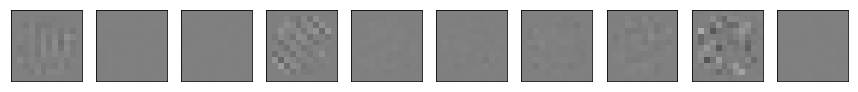

average of data patches =  1.162793067911255e-05 +/- 0.0076012877829628655
average of residual patches =  1.0105754572623037e-05 +/- 0.0022694118095992217
median energy of data =  0.028686129676146165
average energy of data =  0.05708034923256437 +/- 0.06890564239757233
average energy of residual =  0.01643783809824673 +/- 0.019406587043450975
median energy of residual =  0.008096191343420336
average gain of coding =  3.907410717102377 +/- 1.3985544565998065


In [10]:
from shl_scripts.shl_encode import sparse_encode
sparse_code = {}
for homeo_method in ['HEH', 'None']:
    if dico[homeo_method].P_cum is None: 
        gain = np.ones(shl.n_dictionary)
    else:
        gain = None
    sparse_code[homeo_method] = sparse_encode(data[indx, :], dico[homeo_method].dictionary, 
                                 P_cum=dico[homeo_method].P_cum, l0_sparseness = shl.l0_sparseness, C=C, gain=gain)
    SD, SE = print_stats(data[indx, :], dico[homeo_method].dictionary, sparse_code[homeo_method])

In [11]:
sparse_code[homeo_method].shape

(2048, 529)

In [12]:
help(ax.fill_between)

Help on method fill_between in module matplotlib.axes._axes:

fill_between(x, y1, y2=0, where=None, interpolate=False, step=None, *, data=None, **kwargs) method of matplotlib.axes._subplots.AxesSubplot instance
    Make filled polygons between two curves.
    
    
    Create a :class:`~matplotlib.collections.PolyCollection`
    filling the regions between *y1* and *y2* where
    ``where==True``
    
    Parameters
    ----------
    x : array
        An N-length array of the x data
    
    y1 : array
        An N-length array (or scalar) of the y data
    
    y2 : array
        An N-length array (or scalar) of the y data
    
    where : array, optional
        If `None`, default to fill between everywhere.  If not `None`,
        it is an N-length numpy boolean array and the fill will
        only happen over the regions where ``where==True``.
    
    interpolate : bool, optional
        If `True`, interpolate between the two lines to find the
        precise point of intersection

Average of non-zero coefficients 0.028297236826559546 ~= 0.02835538752362949
Mean of non-zero coefficients 57.95274102079395 ~= 58.071833648393195
Mean of non-zero coefficients 57.95274102079395 +/- 25.131932350651656
Median of non-zero coefficients 53.0
Average of non-zero coefficients 0.028313851311436673 ~= 0.02835538752362949
Mean of non-zero coefficients 57.986767485822305 ~= 58.071833648393195
Mean of non-zero coefficients 57.986767485822305 +/- 27.416238043437758
Median of non-zero coefficients 52.0


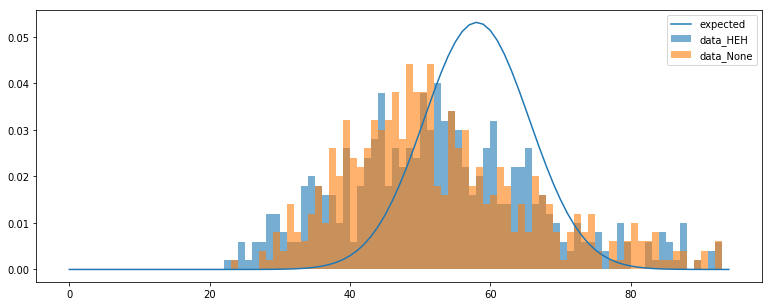

In [13]:
rho = shl.l0_sparseness / shl.n_dictionary
sd = np.sqrt(rho*(1-rho)*record_num_batches)

fig, ax= plt.subplots(figsize=(13, 5))
for homeo_method in ['HEH', 'None']:
    print('Average of non-zero coefficients', (sparse_code[homeo_method]>0).mean(), '~=', rho)
    n_i = np.count_nonzero(sparse_code[homeo_method], axis=0)
    print('Mean of non-zero coefficients', n_i.mean(), '~=', rho*record_num_batches)
    print('Mean of non-zero coefficients', n_i.mean(), '+/-', n_i.std())
    print('Median of non-zero coefficients', np.median(n_i))
    smarts, edges = np.histogram(n_i, density=True, bins=bins)
    smarts /= smarts.sum()
    # ax.step(edges, np.hstack((smarts, 0)), where='pre', label='data_' + homeo_method);
    ax.fill_between(edges[:-1], smarts, step='pre', label='data_' + homeo_method, alpha=.6);

proba = 1 / np.sqrt(2*np.pi) / sd *  np.exp(-.5 * (edges - rho*record_num_batches)**2 / sd**2)
#proba /= proba.sum()
ax.plot(edges, proba, label='expected')
ax.legend();

In [14]:
rho, sparse_code[homeo_method].mean()

(0.02835538752362949, 0.004039441380681249)

## measuring the distance to independance 

In [15]:
for homeo_method in ['HEH', 'None']:
    measures = np.count_nonzero(sparse_code[homeo_method], axis=0)
    # likelihood = 1 / np.sqrt(2*np.pi) / sd *  np.exp(-.5 * (measures - rho)**2 / sd**2)
    logL = -.5 * (measures - rho)**2 / sd**2
    logL += np.log(1 / np.sqrt(2*np.pi) / sd)
    print ('log-likelihood for homeo_method=', homeo_method, 'is', logL.mean(), '+/-', logL.std())
    #return logL.mean()

log-likelihood for homeo_method= HEH is -38.26402240179685 +/- 46.46358859135313
log-likelihood for homeo_method= None is -39.36263792496076 +/- 73.42365258813257


## Version used

In [16]:
%load_ext version_information
%version_information numpy, shl_scripts, pandas

Software versions
Python 3.6.4 64bit [GCC 4.2.1 Compatible Apple LLVM 9.0.0 (clang-900.0.39.2)]
IPython 6.2.1
OS Darwin 17.4.0 x86_64 i386 64bit
numpy 1.14.0
shl_scripts 20171221
pandas 0.22.0
Sat Feb 17 09:54:05 2018 CET